In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files, ttprint
from eumap.raster import read_rasters, save_rasters
from eumap.mapper import SpaceOverlay
import geopandas as gpd
from pathlib import Path
import rasterio
import pyproj
from shapely.geometry import Point
from eumap.mapper import LandMapper
from scipy.special import expit, logit

import warnings

import matplotlib
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

import joblib
import pickle

folder = '/home/opengeohub/xuemeng/work_xuemeng/spatiotemporal-soc-eu/'
df = pd.read_csv(f'{folder}/data/005.0_train.pnts_soc.csv',low_memory=False)

# settle the covariate list and target variable
meta_info = ['id','lat','lon','time','ref','nuts0','geometry','tile_id']
meta_prop = ['oc','ph_h2o','ph_cacl2','bulk_density','clay','silt','sand','caco3','N','K','P','CEC','EC']
meta_qa = [i+'_qa' for i in meta_prop]
meta = meta_info + meta_prop + meta_qa
covs = [i for i in df.columns if i not in meta]
dff = df.dropna(subset=covs,how='any')

dff = dff.loc[dff['oc'].notna()]
dff = dff.loc[dff['oc']>5]
dff = dff.loc[dff['ref']!='nl.bis']
dff.loc[:,'oc_log1p'] = np.log1p(dff['oc'])
tgt = 'oc_log1p'

# # read in annual covariates
# with open('/mnt/inca/soc_eu_model/data/005_covar_annual.static.txt', 'r') as file:
#     lines = file.readlines()
# covs_annual = [line.strip() for line in lines]

# 40% of data for feature selection
fraction = 0.4
train = dff.groupby('tile_id', group_keys=False).apply(lambda x: x.sample(frac=fraction))


### Feature selection with RFECV

[15:33:04] Finding n_features_to_select using RFECV (repetitions=5 step=16), data size 51559
[15:33:04] loop 0


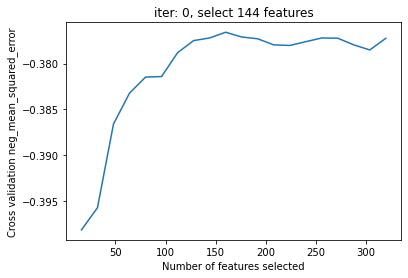

[16:37:14] loop 1


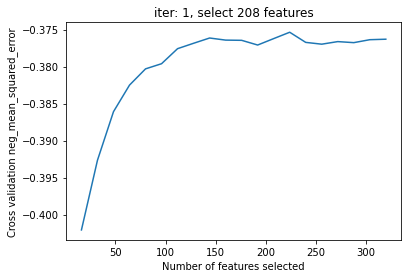

[17:36:38] loop 2


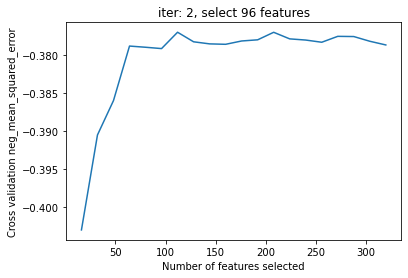

[18:42:43] loop 3


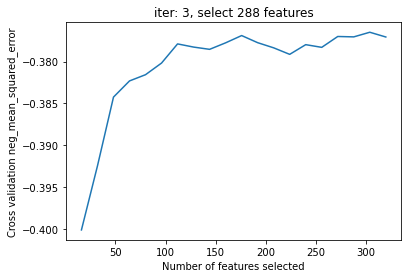

[19:33:57] loop 4


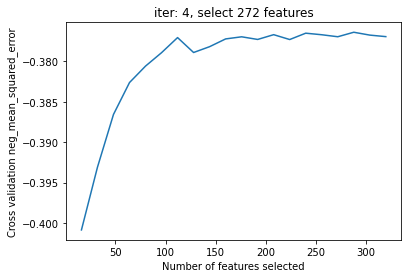

[20:27:11] Finding best features using RFE (n_features_to_select = 176)


In [2]:
# a function to determine optimal number of features
from sklearn.model_selection import GroupKFold, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, RFE
from scipy.signal import argrelmin, argrelmax
import joblib
import random
import multiprocessing

def run_rfecv(data, covs, target_column, scoring, min_feature = 10, errorbar=True, spatial_cv_column = None, n_rep = 5, n_cv = 3, ntrees = 100, local_max_pos = 1):
    rfecv_step = int(len(covs) * 0.05)
    random_numbers = [random.randint(0, 99) for _ in range(n_rep)]

    ncpu = multiprocessing.cpu_count()
    if ntrees < ncpu:
        ncpu = ntrees

    ttprint(f"Finding n_features_to_select using RFECV (repetitions={n_rep} step={rfecv_step}), data size {len(data)}")
    
    grid_scores = []
    rfecv_n_features_arr = np.arange(len(covs), min_feature-1, - rfecv_step)[::-1]
    for i in range(0,n_rep):
        # randomly select subsample of the data to do the rfecv
        ttprint(f'loop {i}')
        
        # cross validation with spatial blocking
        cv, groups = KFold(n_cv), None
        if spatial_cv_column is not None:
            cv, groups = GroupKFold(n_cv), train[spatial_cv_column]
        
        # start the RFECV process
        rfecv = RFECV(estimator=RandomForestRegressor(n_estimators=ntrees, n_jobs=ncpu, random_state=random_numbers[i]), cv=cv, step=rfecv_step, 
            min_features_to_select=min_feature, n_jobs=n_cv, scoring=scoring, verbose=0)
        rfecv.fit(data[covs], data[target_column], groups=groups)
        
        # get the score and visualize
        grid_scores += [rfecv.cv_results_['mean_test_score']]
    
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel(f'Cross validation {scoring}')
        plt.title(f'iter: {i}, select {rfecv.n_features_} features')
#         print(rfecv.cv_results_["mean_test_score"])
        if errorbar:
            plt.errorbar(
                rfecv_n_features_arr,
                rfecv.cv_results_["mean_test_score"][0:-1],
                yerr=rfecv.cv_results_["std_test_score"][0:-1],
            )
        else:
            plt.plot(rfecv_n_features_arr, rfecv.cv_results_["mean_test_score"][0:-1])
        plt.show()

    rfecv_mean_score = np.mean(np.stack(grid_scores, axis=0), axis=0)
    grid_scores_std = np.std(np.stack(grid_scores, axis=0), axis=0)
    
#     local_min_arr = argrelmin(rfecv_mean_score, order=1)[0]
#     local_min = local_min_arr[0]
#     if len(local_min_arr) > 1:
#         local_min = local_min_arr[local_min_pos]
    local_max_arr = argrelmax(rfecv_mean_score, order=1)[0]
    local_max = local_max_arr[0]
    if len(local_max_arr) > 1:
        local_max = local_max_arr[local_max_pos]
    n_features_to_select = rfecv_n_features_arr[local_max]

    ttprint(f"Finding best features using RFE (n_features_to_select = {n_features_to_select})")
    
    return grid_scores, rfecv_mean_score, grid_scores_std, n_features_to_select 

# rfecv selection
grid_scores, rfecv_mean_score, grid_scores_std, feature_num = run_rfecv(train, covs, tgt, scoring = 'neg_mean_squared_error', errorbar=False,spatial_cv_column='tile_id')


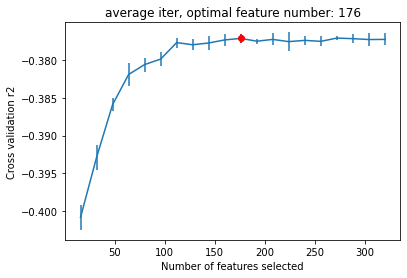

In [3]:
min_feature = 10
rfecv_step = int(len(covs) * 0.05)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel(f'Cross validation r2')
plt.title(f'average iter, optimal feature number: {feature_num}') 

number_arr = np.arange(len(covs), min_feature-1, -rfecv_step)[::-1]

plt.errorbar(number_arr, rfecv_mean_score[0:-1], yerr=grid_scores_std[0:-1])

specific_index = np.where(number_arr == feature_num)[0][0]

plt.errorbar(
    feature_num,
    rfecv_mean_score[specific_index],
    yerr=grid_scores_std[specific_index],
    fmt='o', color='red', label=f'Optimal feature number')
    
plt.show()

#### Determine the optimal set of covariate number with RFE

In [ ]:
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, n_jobs=70, random_state=0),
          step=int(len(covs) * 0.02),
          n_features_to_select=feature_num,
          verbose=0)

# train, _ = train_test_split(dff, test_size=0.5, random_state=42, stratify=dff['tile_id'])
# train = dff.groupby('tile_id', group_keys=False).apply(lambda x: x.sample(min(len(x), 10)))

rfe.fit(train[covs], train[tgt].values)
selected_features = np.array(covs)[rfe.support_]

# get the feature importance
rf = RandomForestRegressor(n_estimators=50, n_jobs=80, random_state=0)
rf.fit(train[selected_features], train[tgt].values)
# train_r2 = rf.score(train_set[selected_features], train_set[tgt].values)
# test_r2 = rf.score(test_set[selected_features], test_set[tgt].values)
# print("Training R^2 score:", train_r2)
# print("Testing R^2 score:", test_r2)

importances = rf.feature_importances_
feature_importances = dict(zip(selected_features, importances))
feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
feature_importances = dict(feature_importances)

with open(f'{folder}/features/001_selected.covar_rfecv.txt', 'w') as file:
    for item in selected_features:
        file.write(f"{item}\n")
     
feature_importances


### Rank frequency

[20:00:07] Finding n_features_to_select using RFECV (repetitions=5 step=7)
[20:00:07] loop 0, training data size: 38121


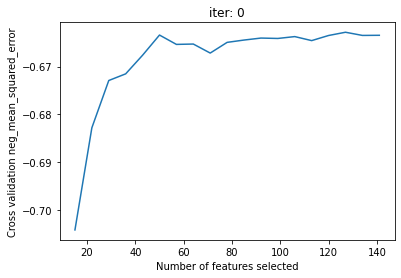

[20:03:53] loop 1, training data size: 38121


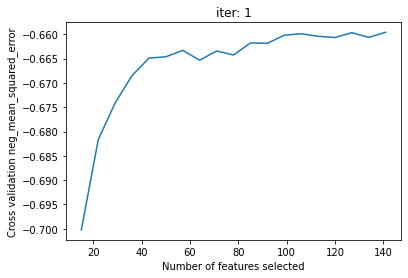

[20:06:38] loop 2, training data size: 38121


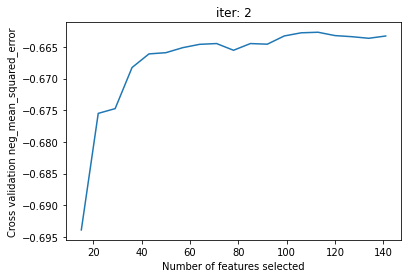

[20:10:29] loop 3, training data size: 38121


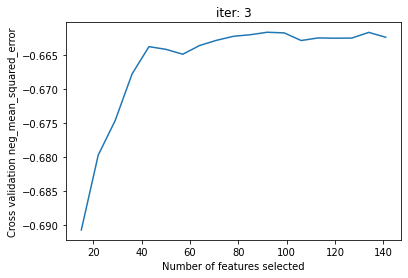

[20:15:45] loop 4, training data size: 38121


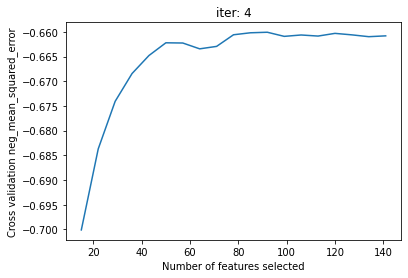

[20:18:26] Finding best features using RFE (n_features_to_select = 106)


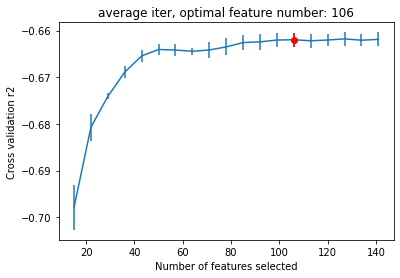

In [19]:
from sklearn.ensemble import RandomForestRegressor
def run_rankcv(data, covs, tgt, spatial_cv_column, weights_feature=None, n_bootstrap=20, ntrees = 100):

    groups = data[spatial_cv_column].unique()
    runs = []
    
    # loop on different bootstrap
    for k in range(n_bootstrap):
        
        np.random.seed(k)
        selected_groups = np.random.choice(groups, int(len(groups) * 0.7), False)  # each time cover 70% of the tiles
        samples_train = data[data[spatial_cv_column].isin(selected_groups)]
        train = samples_train.groupby(spatial_cv_column, group_keys=False).apply(lambda x: x.sample(min(len(x), 20)))  # make sure to select enough data for training
        
        ttprint(f'{k} iteration, training size: {len(train)}')
        # Get weights if applicable
        if weights_feature:
            weights = train[weights_feature].to_numpy()
            rf = RandomForestRegressor(random_state=41, n_jobs=80, n_estimators=ntrees)
            rf.fit(train[covs], train[tgt], sample_weight=weights)
        else:
            rf = RandomForestRegressor(random_state=41, n_jobs=80, n_estimators=ntrees)
            rf.fit(train[covs], train[tgt])

        importances = pd.Series(rf.feature_importances_, index=covs).sort_values(ascending=True)
        importances = importances[importances>=importances.mean()]
        runs.append((importances.index, np.array(importances.to_list())))
        
    result = pd.DataFrame(
        dict(feature=[feature for run in runs for feature in run[0]], 
             importance=[importance for run in runs for importance in run[1]])
    )

    return result


result = run_rankcv(dff, covs, tgt, spatial_cv_column='tile_id')
feature_list = result.groupby(['feature']).count().rename(columns=dict(importance='freq')).reset_index()

features_freq = feature_list.groupby('freq').count().reset_index().sort_values(by='freq', ascending=False)
features_freq['accum'] = features_freq['feature'].cumsum()
features_freq

In [ ]:
print(feature_list.sort_values(by='freq', ascending=False).to_string())

In [ ]:
def find_knee(df):
    slopes = (df['accum'].diff(-1)) / (df['freq'].diff(-1))*(-1)
    knee_index = slopes.idxmax()
    return knee_index

knee_index = find_knee(features_freq)
knee_freq = features_freq.loc[knee_index]['freq']

# import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(features_freq['freq'], features_freq['accum'], 'bo-')  # blue dots with line
plt.xlabel('Frequency')
plt.ylabel('Cumulative feature numbers')
plt.title(f"The knee point is at freq = {knee_freq}, optimal feature number: {features_freq.loc[knee_index]['accum']}")
plt.vlines(knee_freq, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

In [ ]:
selected_features = feature_list[feature_list['freq']>=knee_freq]['feature'].tolist()
with open(f'{folder}/features/002_selected.covar_rank.freq.txt', 'w') as file:
    for item in selected_features:
        file.write(f"{item}\n")